In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import itertools
from sklearn.metrics import roc_auc_score
import pandas as pd
import pickle

In [2]:
EXP_ROOT = "/scratch/zeiberg.d/leveragingStructureFinalExperiments/experiments/"

In [3]:
REAL_DATASETS = ["income","employment","income_poverty_ratio","amazon_reviews"]

In [4]:
class Experiment:
    def __init__(self,pth):
        self.path = pth
        self.loadLabels()
        self.loadPreds()

    def loadLabels(self):
        try:
            self.yUnlabeledTest = np.load(os.path.join(self.path,
                                                      "yUnlabeledTest.npy"))
        except FileNotFoundError:
            self.yUnlabeledTest = None
            
    def loadLabels(self):
        try:
            self.yUnlabeledTest = np.load(os.path.join(self.path,
                                                      "yUnlabeledTest.npy"))
        except FileNotFoundError:
            self.yUnlabeledTest = None

    def getK(self):
        if not np.isnan(self.k):
            return self.k
        try:
            with open(os.path.join(self.path,"mm","clusterer.pkl"),"rb") as f:
                clusterer = pickle.load(f)
                self.clusterer = clusterer
            self.k = clusterer.n_clusters
        except FileNotFoundError:
            self.k = np.nan
        return self.k
        
    def loadPreds(self,skipsteps=[]):
        self.methodPreds = {}
        try:
            self.methodPreds["Group-Aware Global"] = np.load(os.path.join(self.path,
                                                                        "ag",
                                                                        "preds.npy"))
        except FileNotFoundError:
            return
        try:
            self.methodPreds["Cluster Global"] = np.load(os.path.join(self.path,
                                                                      "mm",
                                                                      "clusterGlobalPreds.npy"))

            self.methodPreds["Our Method"] = np.load(os.path.join(self.path,
                                                          "mm",
                                                          "preds.npy"))
        except FileNotFoundError:
            return
        
        try:
            self.methodPreds["Global Star"] = np.load(os.path.join(self.path,
                                                            "mmStar",
                                                            "clusterGlobalPreds.npy"))
            self.methodPreds["Star"] = np.load(os.path.join(self.path,
                                                            "mmStar",
                                                            "preds.npy"))
        except FileNotFoundError:
            return
        
        try:
            self.methodPreds["Global"] = np.load(os.path.join(self.path,
                                                              "mm2",
                                                              "clusterGlobalPreds.npy"))

            self.methodPreds["Label Shift"] = np.load(os.path.join(self.path,
                                                                   "mm2",
                                                                   "Preds.npy"))

        except FileNotFoundError:
            return
        try:
            self.methodPreds["coral"] = np.load(os.path.join(self.path,
                                                            "fe",
                                                            "preds.npy"))
        except FileNotFoundError:
            return
    def aucSeries(self):
        names, vals = list(zip(*[(m,roc_auc_score(self.yUnlabeledTest,preds)) for m,preds in self.methodPreds.items()]))
        return pd.Series(data=vals,index=names)

In [5]:
exp_sets = {}
for setting in range(1,3):
    for name in REAL_DATASETS:
        print(setting,name)
        exp_sets[(name,setting)] = [Experiment(pth) for pth in glob(f"/scratch/zeiberg.d/leveragingStructureFinalExperiments/experiments/{name}_setting_{setting}_*/")]

1 income
1 employment
1 income_poverty_ratio
1 amazon_reviews
2 income
2 employment
2 income_poverty_ratio
2 amazon_reviews


In [6]:
synth_exp_sets = {}
for setting in range(1,3):
    for dim in [1,4,16,64]:
        for nClusters in [1,2,4,8]:
            print(setting,dim,nClusters)
            synth_exp_sets[(setting,dim,nClusters)] = [Experiment(pth) for pth in \
                                                      glob(os.path.join(EXP_ROOT,f"synthetic_dim_{dim}_nClusters_{nClusters}_setting_{setting}_*/")) \
                                                      if "FAILED" not in pth]

1 1 1
1 1 2
1 1 4
1 1 8
1 4 1
1 4 2
1 4 4
1 4 8
1 16 1
1 16 2
1 16 4
1 16 8
1 64 1
1 64 2
1 64 4
1 64 8
2 1 1
2 1 2
2 1 4
2 1 8
2 4 1
2 4 2
2 4 4
2 4 8
2 16 1
2 16 2
2 16 4
2 16 8
2 64 1
2 64 2
2 64 4
2 64 8


In [7]:
tables = {}
for k,exps in exp_sets.items():
    print(k)
    series = []
    for e in exps:
        try:
            series.append(e.aucSeries())
        except ValueError:
            print(e.path)
    tables[k] = pd.DataFrame(series)

('income', 1)
('employment', 1)
('income_poverty_ratio', 1)
/scratch/zeiberg.d/leveragingStructureFinalExperiments/experiments/income_poverty_ratio_setting_1_3/
/scratch/zeiberg.d/leveragingStructureFinalExperiments/experiments/income_poverty_ratio_setting_1_2/
/scratch/zeiberg.d/leveragingStructureFinalExperiments/experiments/income_poverty_ratio_setting_1_4/
('amazon_reviews', 1)
('income', 2)
('employment', 2)
('income_poverty_ratio', 2)
('amazon_reviews', 2)


In [9]:
import pathlib

missing = []
for k,exps in exp_sets.items():
    rt = pathlib.Path(exps[0].path).name
    rt = rt[:rt.rfind("_")]
    exp_names = set([pathlib.Path(e.path).name for e in exps])
    for num in range(25):
        pth = rt+f"_{num}"
        if pth not in exp_names:
            missing.append(pth)

In [10]:
missing

[]

In [11]:
synth_tables = {}
synth_missing = []
for k,exps in synth_exp_sets.items():
    series = []
    for e in exps:
        try:
            series.append(e.aucSeries())
        except ValueError:
            p = pathlib.Path(e.path).name
            print("cannot process ",p)
            synth_missing.append(p)
            continue
    synth_tables[k] = pd.DataFrame(series)

In [12]:
len(synth_missing)

0

In [13]:
synth_missing

[]

In [14]:
missing_dict = {}
for setting in range(1,3):
    for dim in [1,4,16,64]:
        for nClusters in [1,2,4,8]:
            template = f"synthetic_dim_{dim}_nClusters_{nClusters}_setting_{setting}_"
            names = [e for e in synth_missing if template in e]
            if len(names):
                missing_dict[(dim,nClusters,setting)] = ",".join([n[n.rfind("_")+1:] for n in names])

In [50]:
tables[('income_poverty_ratio', 1)]

,Group-Aware Global,Cluster Global,Our Method,Global Star,Star,Global,Label Shift,coral
0,0.811445,0.825663,0.818654,0.824869,0.815342,0.825017,0.815345,0.790321
1,0.812983,0.828818,0.817372,0.826231,0.818049,0.825291,0.816864,NaN
2,0.812679,0.831991,0.813065,0.826089,0.812575,0.826029,0.812653,0.798728
3,0.811057,0.827903,0.815725,0.825869,0.815593,0.825006,0.814456,NaN
4,0.811011,0.827642,0.811653,0.825167,0.809513,0.825684,0.810598,NaN
5,0.811226,0.827063,0.811489,0.824367,0.813636,0.824454,0.813579,0.789512
6,0.809605,0.831073,0.812973,0.823010,0.808163,0.823202,0.808419,0.783738
7,0.811635,0.828107,0.812783,0.824933,0.811266,0.825111,0.811348,NaN
8,0.812095,0.828996,0.818985,0.826140,0.818545,0.825924,0.818463,NaN
9,0.811188,0.828629,0.819530,0.824952,0.816602,0.825229,0.817100,0.792604


### Real-Data Experiment Iteration Counts without CORAL

In [45]:
[(n,t[[c for c in t.columns if c != "coral"]].dropna().shape[0]) for n,t in tables.items()]

[(('income', 1), 25),
 (('employment', 1), 23),
 (('income_poverty_ratio', 1), 22),
 (('amazon_reviews', 1), 25),
 (('income', 2), 25),
 (('employment', 2), 23),
 (('income_poverty_ratio', 2), 25),
 (('amazon_reviews', 2), 24)]

### Real-Data Experiment Iteration Counts `with` CORAL

In [23]:
[(n,t.dropna().shape[0]) for n,t in tables.items()]

[(('income', 1), 25),
 (('employment', 1), 21),
 (('income_poverty_ratio', 1), 11),
 (('amazon_reviews', 1), 25),
 (('income', 2), 25),
 (('employment', 2), 23),
 (('income_poverty_ratio', 2), 24),
 (('amazon_reviews', 2), 24)]

In [54]:
synth_exp_sets[(1,1,8)][9].path

'/scratch/zeiberg.d/leveragingStructureFinalExperiments/experiments/synthetic_dim_1_nClusters_8_setting_1_18/'

In [51]:
synth_tables[(1,1,8)]

,Group-Aware Global,Cluster Global,Our Method,Global Star,Star,Global,Label Shift,coral
0,0.839754,0.882883,0.876631,0.905860,0.900926,0.888101,0.888046,0.887875
1,0.839565,0.889490,0.882717,0.891643,0.887817,0.893989,0.893919,0.893801
2,0.803099,0.830869,0.830663,0.847515,0.843344,0.832790,0.832667,0.832699
3,0.851376,0.894930,0.894674,0.905162,0.902400,0.896661,0.896590,0.896373
4,0.816274,0.889776,0.889452,0.895970,0.892625,0.891353,0.891228,0.891386
5,0.835565,0.866177,0.865221,0.886956,0.882900,0.869894,0.869757,0.869927
6,0.779266,0.830305,0.828495,0.830419,0.825513,0.834811,0.834529,0.834587
7,0.848568,0.868380,0.867423,0.869785,0.866288,0.871028,0.870939,0.870998
8,0.826458,0.876901,0.876841,0.877034,0.874239,0.878157,0.878100,0.878052
9,0.820041,0.863106,0.863003,NaN,NaN,NaN,NaN,NaN


In [55]:
sorted([(n,t.dropna().shape[0]) for n,t in synth_tables.items()],key=lambda tup: tup[1])

[((1, 1, 8), 24),
 ((1, 64, 1), 24),
 ((1, 64, 8), 24),
 ((2, 64, 1), 24),
 ((2, 64, 8), 24),
 ((1, 1, 1), 25),
 ((1, 1, 2), 25),
 ((1, 1, 4), 25),
 ((1, 4, 1), 25),
 ((1, 4, 2), 25),
 ((1, 4, 4), 25),
 ((1, 4, 8), 25),
 ((1, 16, 1), 25),
 ((1, 16, 2), 25),
 ((1, 16, 4), 25),
 ((1, 16, 8), 25),
 ((1, 64, 2), 25),
 ((1, 64, 4), 25),
 ((2, 1, 1), 25),
 ((2, 1, 2), 25),
 ((2, 1, 4), 25),
 ((2, 1, 8), 25),
 ((2, 4, 1), 25),
 ((2, 4, 2), 25),
 ((2, 4, 4), 25),
 ((2, 4, 8), 25),
 ((2, 16, 1), 25),
 ((2, 16, 2), 25),
 ((2, 16, 4), 25),
 ((2, 16, 8), 25),
 ((2, 64, 2), 25),
 ((2, 64, 4), 25)]

In [25]:
name,vals = zip(*[(n,t.mean(axis=0).sort_values()) for n,t in tables.items()])
summaryTable = pd.DataFrame(vals,index=name)

In [26]:
summaryTable.style.highlight_max(subset=[c for c in summaryTable.columns if "Star" not in c],axis=1)

,,coral,Group-Aware Global,Label Shift,Star,Our Method,Global,Global Star,Cluster Global
income,1,0.865464,0.869568,0.872545,0.872592,0.873501,0.879024,0.879056,0.879184
employment,1,0.882663,0.896964,0.900239,0.900261,0.898593,0.902938,0.902935,0.903199
income_poverty_ratio,1,0.793788,0.811251,0.809641,0.809592,0.811001,0.824868,0.824903,0.828096
amazon_reviews,1,0.688648,0.647865,0.676350,0.734584,0.686734,0.691444,0.703296,0.702600
income,2,0.852626,0.846440,0.875993,0.899863,0.884228,0.869522,0.870757,0.871484
employment,2,0.850948,0.866698,0.903709,0.926750,0.916202,0.896973,0.898198,0.898284
income_poverty_ratio,2,0.761757,0.768209,0.831217,0.861756,0.849960,0.815569,0.820174,0.819832
amazon_reviews,2,0.685938,0.656700,0.678269,0.734889,0.683403,0.688799,0.699615,0.698122


In [27]:
name,vals = zip(*[(n,t.mean(axis=0).sort_values()) for n,t in synth_tables.items()])
synth_summaryTable = pd.DataFrame(vals,index=name)

In [28]:
synth_summaryTable.style.highlight_max(subset=[c for c in synth_summaryTable.columns if "Star" not in c],axis=1)

In [42]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 34})
def plotRelPerf(tbl,savepath=None,ax=None,ticks=True,axLBL=True,title=None,
               cols=lambda tbl:tbl.columns,
               ticklabels = None,
               rel_to="Global",
                ytick_locs=np.arange(-20,25,5)):
    g = tbl[rel_to]
    cols = cols(tbl)
    rel = tbl.loc[:,cols].apply(lambda col: (col-g)/g) * 100
    if ax is None:
        ax = plt.subplot()
    ax.boxplot(rel)
    ax.violinplot(rel)
    if ticks:
        if ticklabels is None:
            ticklabels = cols
        labels = ax.set_xticks(np.arange(1,len(ticklabels)+1),
                        ticklabels,
                        rotation=45,ha="right")
    else:
        ax.tick_params(axis='x',          # changes apply to the x-axis
                           which='both',      # both major and minor ticks are affected
                           bottom=False,      # ticks along the bottom edge are off
                           top=False,         # ticks along the top edge are off
                           labelbottom=False) # labels along the bottom edge are off
    if axLBL:
        ax.set_ylabel("Relative AUC (%)")
        ax.set_yticks(ytick_locs,
                 [str(i) for i in ytick_locs])
    if title is not None:
        ax.set_title(title)
    if savepath is not None:
        plt.savefig(savepath,format="pdf")
    return ax

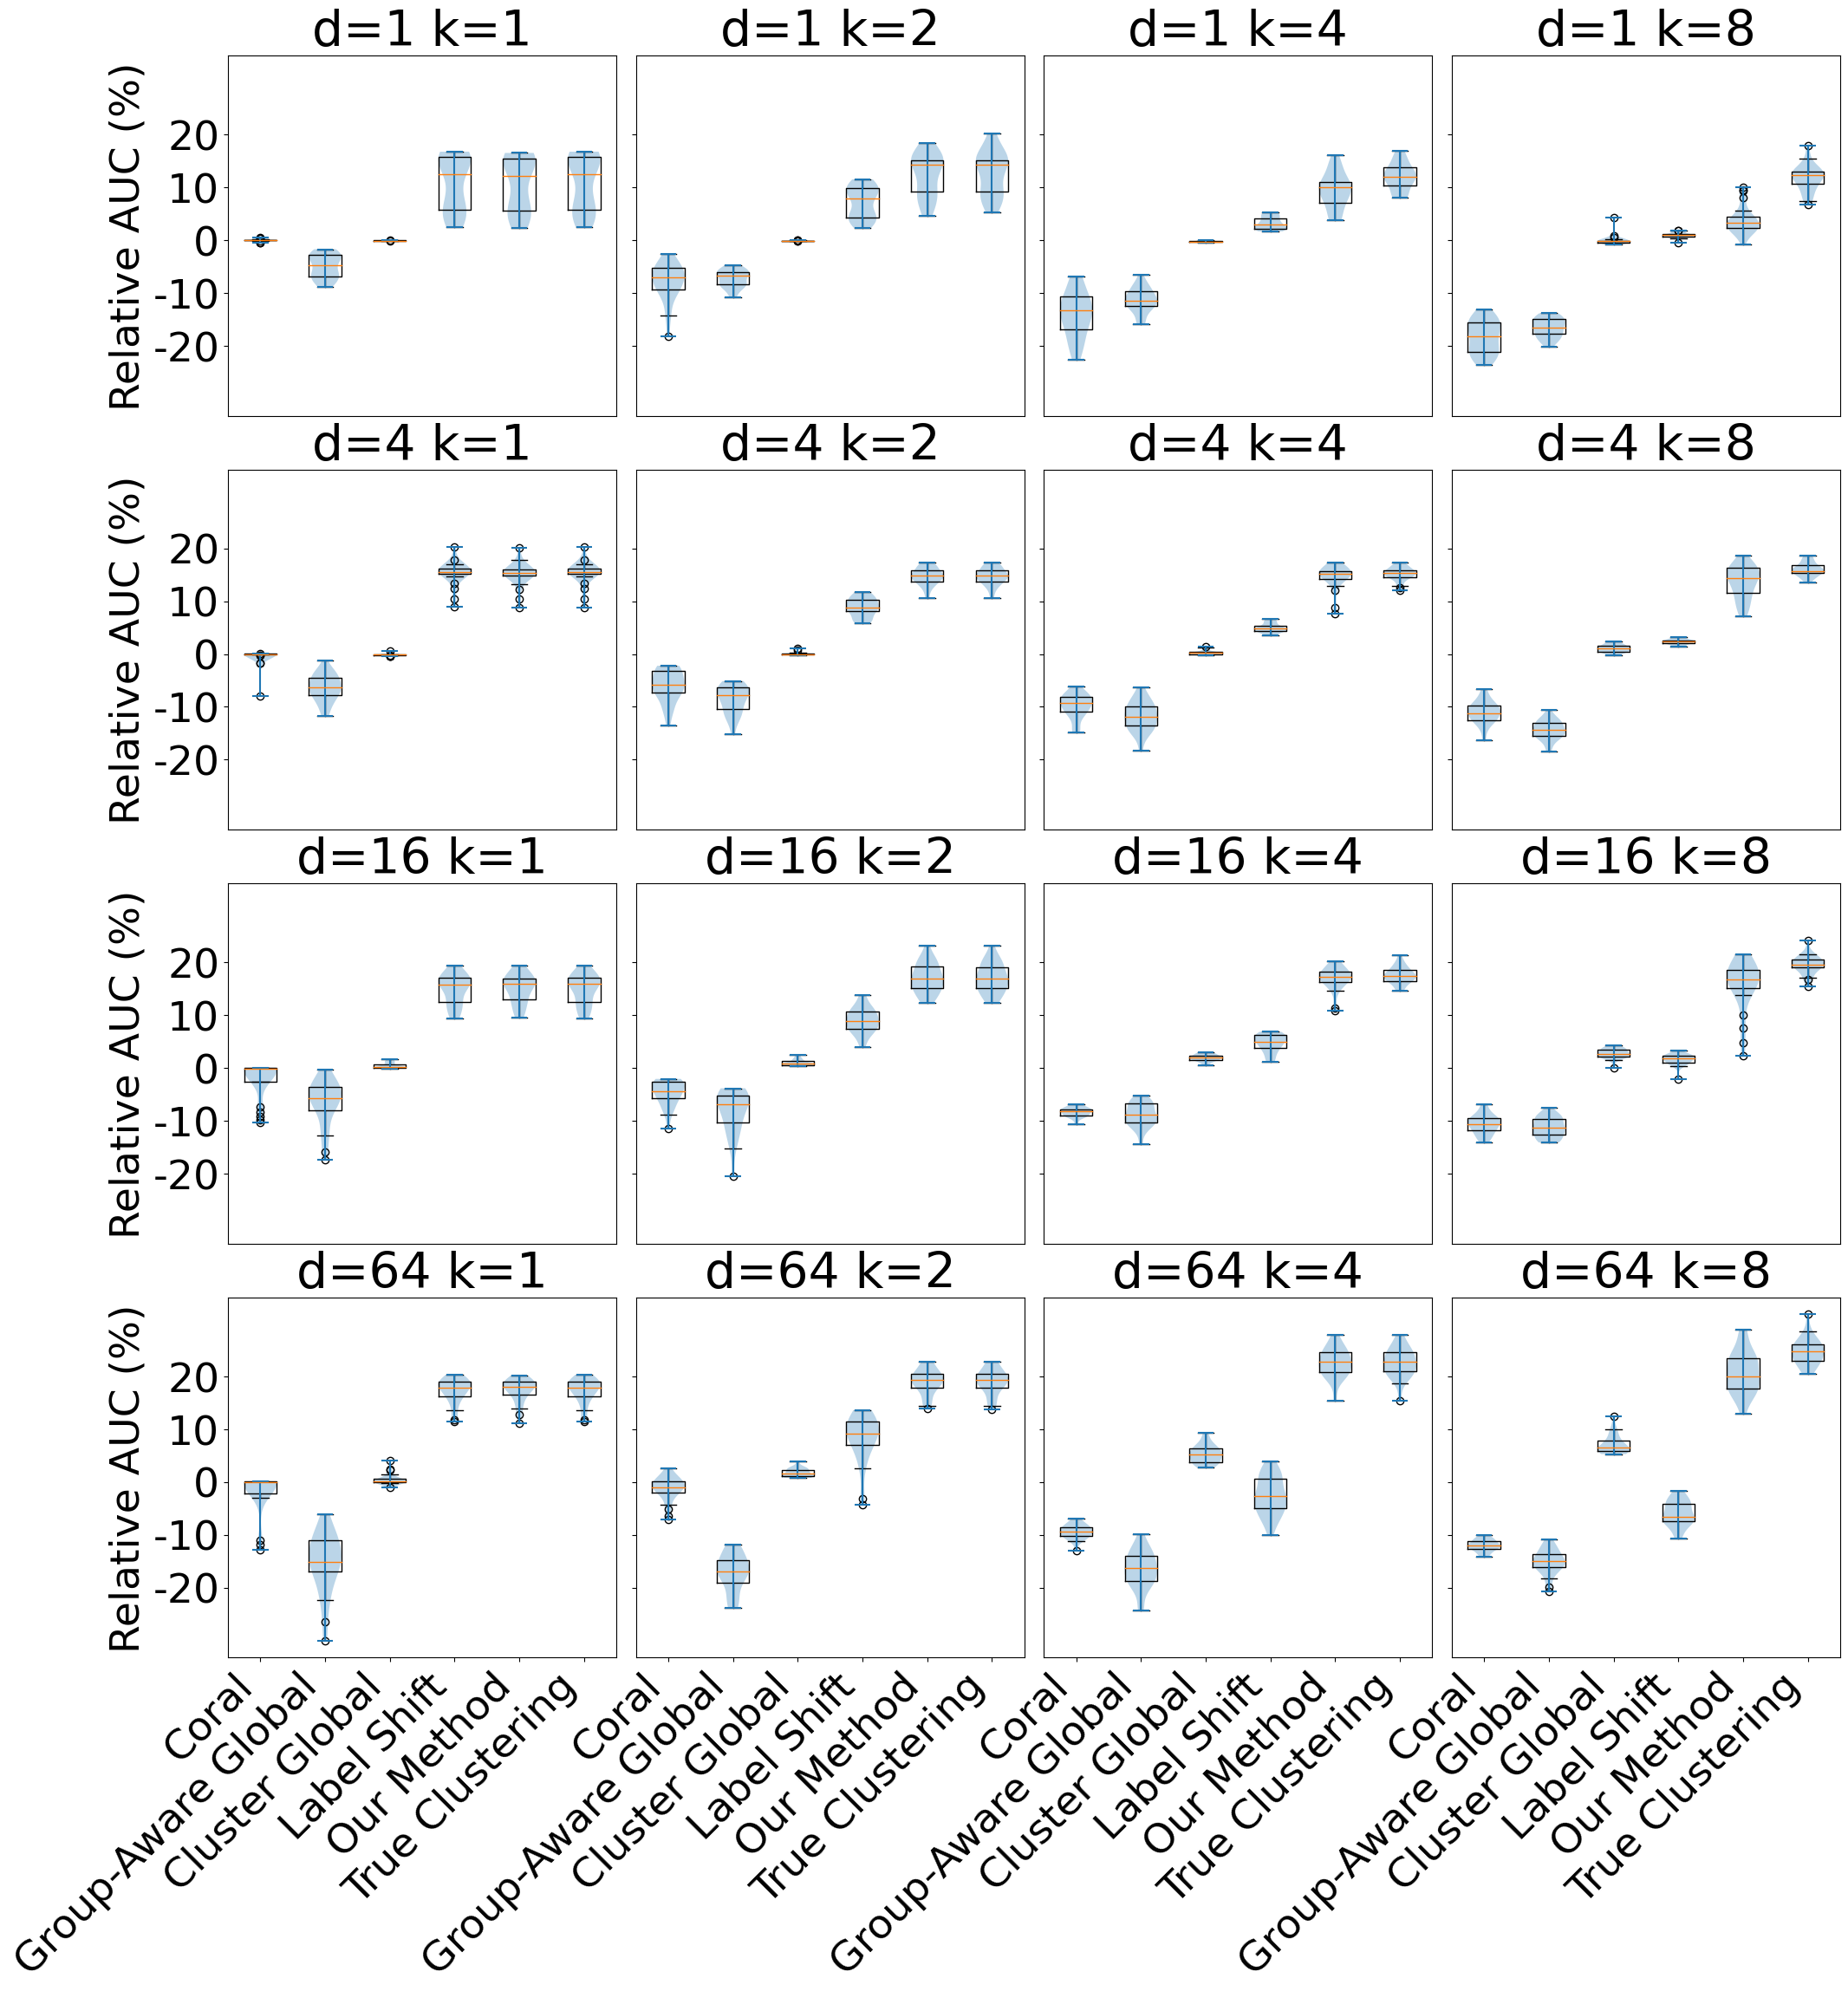

In [43]:
synthDFig2,synthDax2 = plt.subplots(4,4,figsize=(24,24),sharey=True,)
for i,d in enumerate([1,4,16,64]):
    for j,k in enumerate([1,2,4,8]):
        plotRelPerf(synth_tables[(2,d,k)].dropna(),
                    ax=synthDax2[i,j],
                   ticks=i==3,
                   axLBL=j==0,
                   title=f"d={d} k={k}",
                   cols=lambda tbl:["coral","Group-Aware Global",
                                    "Cluster Global",
                                    "Label Shift","Our Method","Star"],
                   ticklabels=["Coral","Group-Aware Global",
                                    "Cluster Global",
                                    "Label Shift","Our Method","True Clustering"],
                   rel_to="Global",ytick_locs=np.arange(-20,30,10))
synthDFig2.subplots_adjust(hspace = .15,wspace=.05)

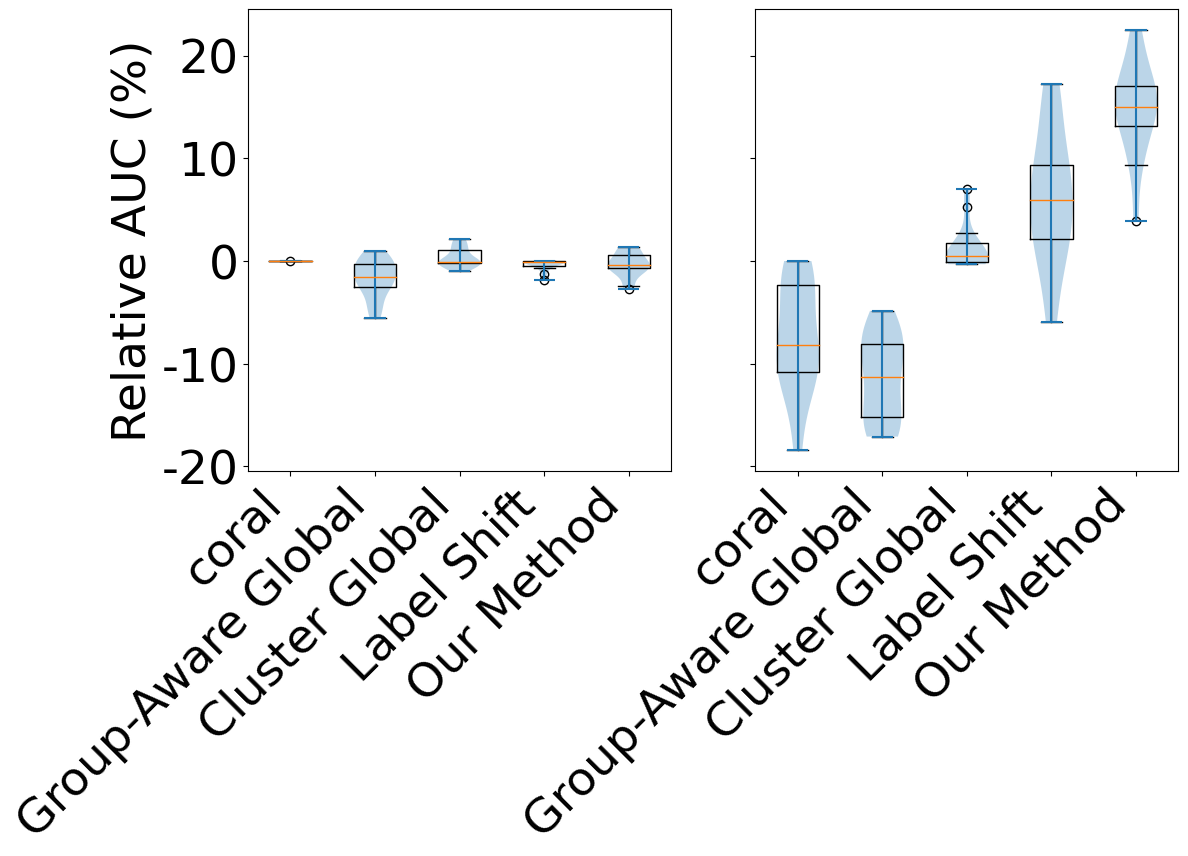

In [44]:
synthfig,synthax= plt.subplots(1,2,figsize=(12,6),sharey=True)

synth1 = plotRelPerf(synth_summaryTable.loc[1],ax=synthax[0],
                     cols=lambda tbl:["coral","Group-Aware Global",
                                      "Cluster Global",
                                      "Label Shift","Our Method"],
                     ytick_locs=np.arange(-20,30,10))

synth2 = plotRelPerf(synth_summaryTable.loc[2],ax=synthax[1],axLBL=False,
                    cols=lambda tbl:["coral","Group-Aware Global",
                                      "Cluster Global",
                                      "Label Shift","Our Method"])